In [1]:
import numpy as np
from tqdm.auto import tqdm
import imageio
import os
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
from scipy.signal import convolve, convolve2d
def init_map_2d(N, C=2):
    """
    N: map size
    C: # of players (default=2)
    return: (C, N, N)
    """
    board = np.random.random_sample((N, N))
    result = np.zeros((C, N, N), dtype=np.uint8)
    for c in range(C):
        result[c] = ((1 / C) * c < board) * (board <= (1 / C) * (c + 1))
    return result

def compress_2d(game_map, N, C):
    """
    game_map: (C, N, N)
    return: (N, N)
    """
    result = np.zeros((N, N))
    for c in range(C):
        result += game_map[c] * c
    return result

def decompress_2d(game_map_2d, N, C):
    """
    game_map_2d: (N, N)
    return: (C, N, N)
    """
    result = np.zeros((C, N, N))
    for c in range(C):
        result[c] = (game_map_2d == c)
    return result#.astype(np.uint8)

def game_step_2d(game_map, r):
    """
    game_map: (C, N, N)
    r: float in [0, 1]
    """
    C, N, N = game_map.shape
    
    kernel_2d = np.ones((3, 3)) 
    kernel_2d[1, 1] = 0 # 3D cube with 0 in center
    
    compressed_map = compress_2d(game_map, N, C)
    neighbours_3d = np.zeros((C, N, N))
    for c in range(C):
        neighbours_3d[c] = convolve2d(game_map[c], kernel_2d, mode='same', boundary='wrap')
        
    neighbours_3d *= game_map
    neighbours = neighbours_3d.max(axis=0)
    moving = neighbours < int(kernel_2d.sum() * r)
    num_moving = moving.sum()
    
    moving_colors = compressed_map[moving]
    np.random.shuffle(moving_colors)
    compressed_map[moving] = moving_colors
    
    updated_map = decompress_2d(compressed_map, N, C)
    return updated_map, num_moving

In [3]:
def game_2d(N, C, r, game_length, name=None, figsize=(14,11)):
    """
    Launch a game with board of size (N, N), C players and game_length iterations
    r: % of neighbours of the same colour
    """
    assert 0 <= r <= 1, "Wrong r value! 0 <= r <= 1"
    game_map = init_map_2d(N, C)
    move_hist = []
    images = []
    for i in tqdm(range(game_length), desc=f'Number of neighbours={int(r*8)}', leave=False):
        game_map, moved = game_step_2d(game_map, r)
        game_map_2d = prepare_2d_plot(game_map)
        fname = f'imgs/{name}.png'
        plot_2d(game_map_2d, C=C, r=r, i=i, save_image=True, name=fname, figsize=figsize)
        images.append(imageio.imread(fname))
        os.remove(fname)
        move_hist.append(moved)
        
    fname = f'imgs/task3/{name}.gif'
    imageio.mimsave(fname, images, fps = 10)
    return move_hist

In [4]:
def prepare_2d_plot(game_map):
    """
    game_map: (C, N, N)
    """
    C, N, N = game_map.shape
    game_map_2d = compress_2d(game_map, N, C)
    return game_map_2d

def plot_2d(game_map_2d, C=2, r=None, i=None, save_image=False, name=None, figsize=(14,11)):
    plt.figure(figsize=figsize)
    
    if C > 2:
        plt.imshow(game_map_2d)
    else:
        plt.imshow(game_map_2d, cmap=plt.cm.gray)
    
    if r:
        plt.title(f'Schelling, r = {r}, iteration = {i}', fontsize=20)
    plt.axis('off')
    if save_image:
        plt.savefig(name)
        plt.close()

In [5]:
R = np.linspace(0, 1, 9)
N = 80
C = 2
game_length = 100

global_moved = []
for i, r in enumerate(R):
    moved = game_2d(N, C, r, game_length, name=f'schelling_{i}', figsize=(6, 6))
    global_moved.append(moved)

Number of neighbours=0:   0%|          | 0/100 [00:00<?, ?it/s]

Number of neighbours=1:   0%|          | 0/100 [00:00<?, ?it/s]

Number of neighbours=2:   0%|          | 0/100 [00:00<?, ?it/s]

Number of neighbours=3:   0%|          | 0/100 [00:00<?, ?it/s]

Number of neighbours=4:   0%|          | 0/100 [00:00<?, ?it/s]

Number of neighbours=5:   0%|          | 0/100 [00:00<?, ?it/s]

Number of neighbours=6:   0%|          | 0/100 [00:00<?, ?it/s]

Number of neighbours=7:   0%|          | 0/100 [00:00<?, ?it/s]

Number of neighbours=8:   0%|          | 0/100 [00:00<?, ?it/s]

![SegmentLocal](imgs/task3/schelling_3.gif "segment")
![SegmentLocal](imgs/task3/schelling_4.gif "segment")
![SegmentLocal](imgs/task3/schelling_5.gif "segment")
![SegmentLocal](imgs/task3/schelling_6.gif "segment")

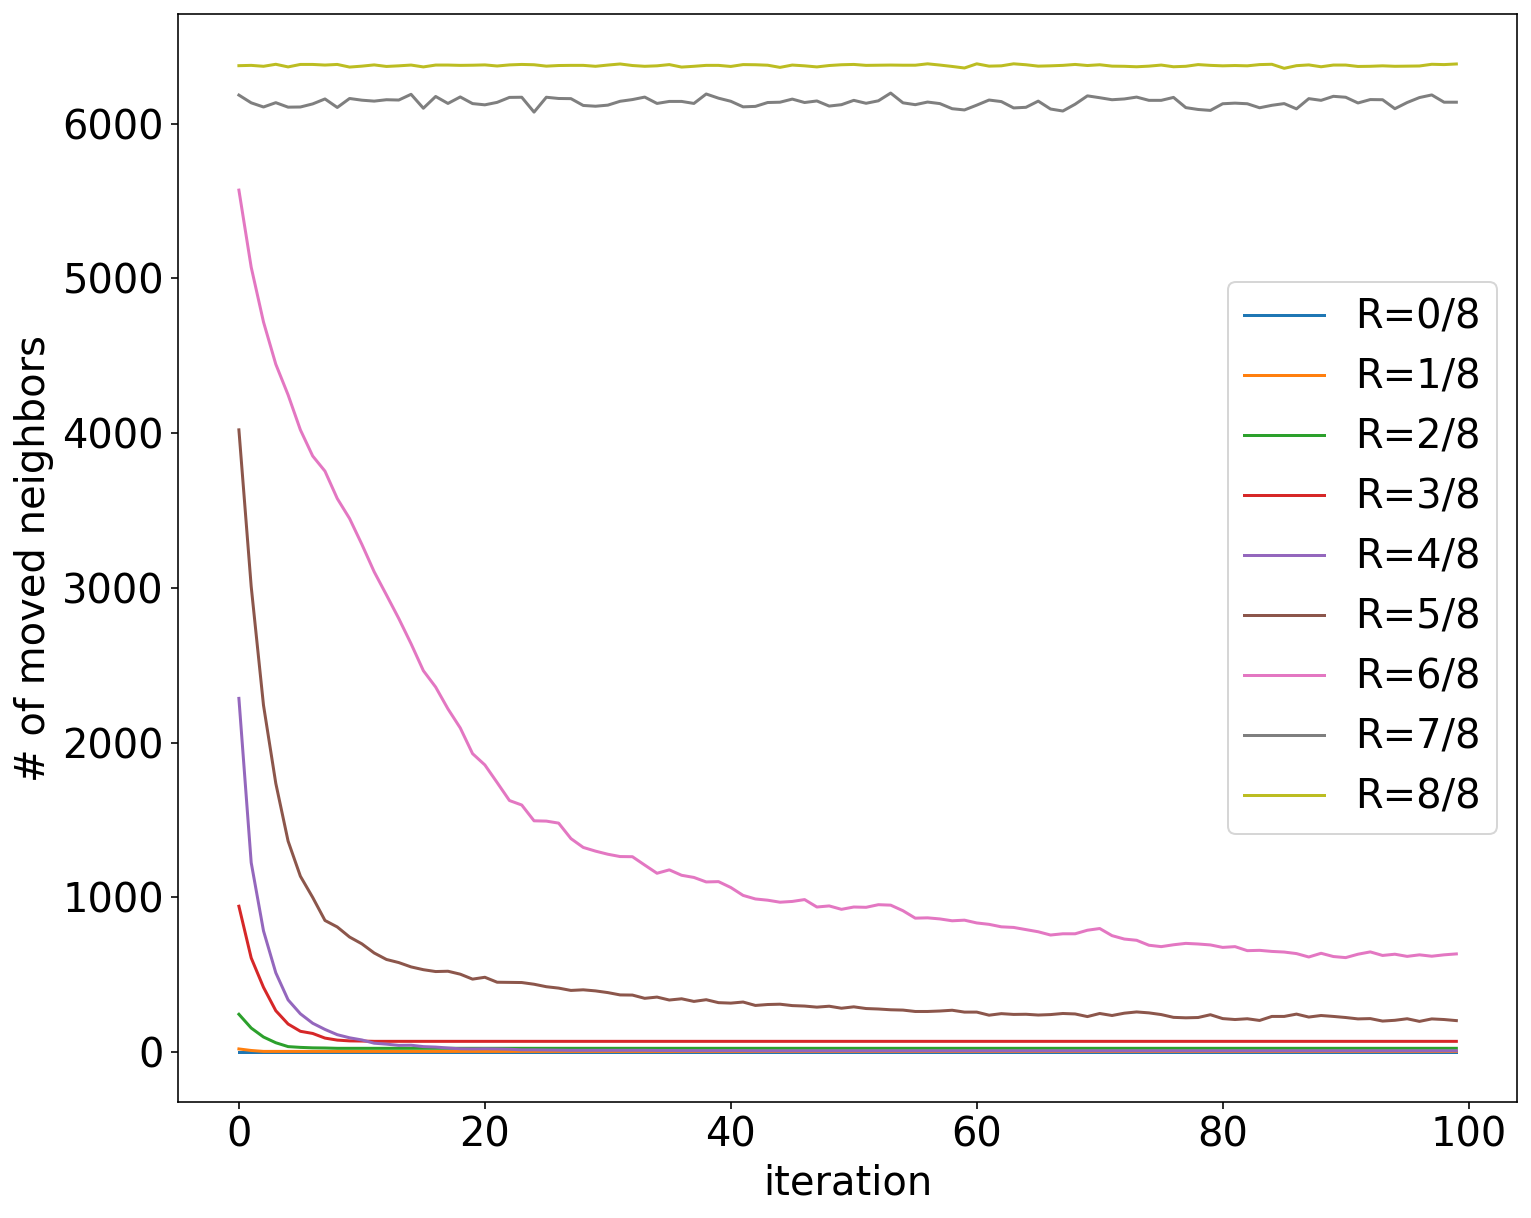

In [6]:
fig, ax = plt.subplots(figsize=(12,10))
for i, r in enumerate(R):
    ax.plot(global_moved[i], label=f'R={int(r*8)}/8')
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.set_xlabel('iteration', fontsize=20)
    ax.set_ylabel('# of moved neighbors', fontsize=20)
    ax.legend(fontsize=20)
plt.show()